In [1]:
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
class Agent(object):
    
    class State(object):
        def __init__(self):
            self.count = {'state': 0, 'hit': 0, 'stick': 0}
            self.action_value = {'hit':0, 'stick':0} # action_value 추가
    
    def __init__(self):       
        self.state_dict = {} # initialization 초기화
        #self.number_of_learning = number_of_learning
        
        for dealer_card in range(1, 11):
            for player_total in range(1, 22):
                self.state_dict[(dealer_card, player_total)] = self.State()
                

In [3]:
class Agent_approx(object):
    def __init__(self):
        self.weight = np.zeros(36) 

In [4]:
def step(state, action):
    
    """
    Args:
        state (tuple) : represent dealer_card and player_total in form of tuple (dealer_card, player_total)
                       state - dealer's first card 1-10 and the player's sum 1-21
        action (str) : 'hit' or 'stick'
    
    returns:
        state (tuple) : next state determined by input action. It could be terminal
        reward (int) : player's win +1, tie 0, lose -1
    """
    
    
    if action == 'hit':
        card = _draw_card()
        
        # update player's total 
        if card[1] == 'BLACK':
            next_state = (state[0], state[1] + card[0])
        elif card[1] == 'RED':
            next_state = (state[0], state[1] - card[0])
        
        # calculate reward
        if next_state[1] > 21 or next_state[1] < 1:
            reward = -1
        else:
            reward = 0
            
    elif action == 'stick':
        # dealer's play
        while True:
            card = _draw_card()
            if card[1] == 'BLACK':
                next_state = (state[0] + card[0], state[1])
            elif card[1] == 'RED':
                next_state = (state[0] - card[0], state[1])
            
            if next_state[0] >= 17 or next_state[0] < 1:
                break
            else:
                continue

        # calculate reward 
        if next_state[0] > 21 or next_state[0] < 1:
            reward = 1
        elif next_state[0] < next_state[1]:
            reward = 1
        elif next_state[0] > next_state[1]:
            reward = -1
        elif next_state[0] == next_state[0]:
            reward = 0

    return next_state, reward

In [5]:
def _draw_card():
    rand_number = random.randrange(1,11)
    color_number = random.randrange(1,4)
    
    if color_number == 1:
        color = 'RED'
    else:
        color = 'BLACK'
    
    return (rand_number, color)

In [6]:
def epsilon_greedy_policy(Agent, state, epsilon=None):
    # N_0 is constant. Feel free to choose an alternative value for N0, if it helps producing better results.
    N_constant = 100
    
    # exploration strategy w/ N_0 / ( N_0 _ N(s_t) ) in MC and Sarsa(\lambda)
    if epsilon == None:
        epsilon = N_constant / (N_constant + Agent.state_dict[state].count['state'])
    
    if Agent.state_dict[state].action_value['hit'] > Agent.state_dict[state].action_value['stick']:
        hit_prob = (epsilon / 2) + 1 - epsilon
        #stick_prob = 1 - hit_prob
    else:
        hit_prob = (epsilon / 2)
    
    random_action = random.random()
    if random_action < hit_prob:
        action = 'hit'
    else:
        action = 'stick'
    
    return action

In [7]:
def optimal_value(Agent):

    optimal_value_dict = {}

    for (i, j) in Agent.state_dict.keys():
        optimal_value_dict[(i, j)] = max(Agent.state_dict[(i, j)].action_value['hit'], Agent.state_dict[(i, j)].action_value['stick'])

    return optimal_value_dict

In [8]:
def optimal_action(Agent):
    optimal_action_dict = {}
    
    for (i, j) in Agent.state_dict.keys():
        if Agent.state_dict[(i, j)].action_value['hit'] > Agent.state_dict[(i, j)].action_value['stick']:
            optimal_action_dict[(i, j)] = 'hit'
        elif Agent.state_dict[(i, j)].action_value['hit'] < Agent.state_dict[(i, j)].action_value['stick']:
            optimal_action_dict[(i, j)] = 'stick'
            
    return optimal_action_dict

In [9]:
def MC_learning(Agent, number_of_learning):
    """
    Args:
        Agent (object) : an agent which we want to make learn
        number_of_learning (int) : number_of_learning
    
    returns(void)

    """
 
    for num in range(0, number_of_learning):
        initial_state = (random.randrange(1,11), random.randrange(1,22))
        initial_action = epsilon_greedy_policy(Agent, initial_state)
        cur_state = initial_state
        cur_action = initial_action
        Agent.state_dict[cur_state].count['state'] += 1
        Agent.state_dict[cur_state].count[cur_action] += 1

        # terminal state까지 반복
        while True:  
            (next_state, reward) = step(cur_state, cur_action)
            if cur_action == 'stick' or reward == -1 : # terminal state
                break
            else:
                cur_state = next_state
                cur_action = epsilon_greedy_policy(Agent, next_state)
                Agent.state_dict[cur_state].count['state'] += 1
                Agent.state_dict[cur_state].count[cur_action] += 1
                continue

        # Q value update
        """Monte-Carlo Control
        N(S_t, A_t) = N(S_t, A_t) + 1 # 위에서 처리
        Q(S_t, A_t) = Q(S_t, A_t) + 1/N(S_t, A_t) * (G_t - Q(S_t, A_t) )
        
        return
        G_t = R_{t+1} + R_{t+2} + ... + R_T (discount factor = 1)
        """
        
        alpha_t = 1 / Agent.state_dict[initial_state].count[initial_action] # step-size alpha
        G_t = reward
        Agent.state_dict[initial_state].action_value[initial_action] = Agent.state_dict[initial_state].action_value[initial_action] + alpha_t * ( G_t - Agent.state_dict[initial_state].action_value[initial_action] )
        

In [10]:
def TD_learning(Agent, number_of_learning, lambda_parameter):
    """
    Args:
        Agent (object) : an agent which we want to make learn
        number_of_learning (int) : number_of_learning
        lambda_parameter (0~1) : parameter values in np.arange(0, 1.1, 0.1)
    
    returns (void)
    """
    
    for num in range(0, number_of_learning):
        step_number = 0
        sum_of_n_step_q_value = 0.0
        terminal_reward = 0.0
        
        initial_state = (random.randrange(1,11), random.randrange(1,22))
        initial_action = epsilon_greedy_policy(Agent, initial_state)
        cur_state = initial_state
        cur_action = initial_action
        Agent.state_dict[cur_state].count['state'] += 1
        Agent.state_dict[cur_state].count[cur_action] += 1

        # terminal state까지 반복
        while True:  
            (next_state, reward) = step(cur_state, cur_action)
            step_number += 1 
            if cur_action == 'stick' or reward == -1 : # terminal state
                terminal_reward = lambda_parameter ** ( step_number - 1 ) * reward
                break
            else:
                cur_state = next_state
                cur_action = epsilon_greedy_policy(Agent, next_state)
                Agent.state_dict[cur_state].count['state'] += 1
                Agent.state_dict[cur_state].count[cur_action] += 1
                sum_of_n_step_q_value += lambda_parameter ** ( step_number - 1 ) * Agent.state_dict[cur_state].action_value[cur_action]
                continue

        # Q value update
        """ Sarsa(\lambda) control
        N(S_t, A_t) = N(S_t, A_t) + 1 # 위에서 처리
        Q(S_t, A_t) = Q(S_t, A_t) + 1/N(S_t, A_t) * (G_t - Q(S_t, A_t) )
        
        n-step q return ( \gamma = 1, no discount )
        q_t^(n) = R_{t+1} + R_{t+2} + ... + R_{t+n} + Q_{t+n} ( S_{t+n}, A_{t+n} ) 
        q_t^(T) = R_{t+1} + ... + R_{t+T-1} + R_{t+T} (Terminal)
        
        q^{lambda} return
        q_t^{lambda} = ( 1 - lambda_parameter ) \Sum_{n=1}^T (lambda_parameter)^{n-1} * q_t^(n)  
        """
        
        alpha_t = 1 / Agent.state_dict[initial_state].count[initial_action] # step-size alpha
        q_lambda = ( 1 - lambda_parameter ) * (sum_of_n_step_q_value) + terminal_reward
        Agent.state_dict[initial_state].action_value[initial_action] = Agent.state_dict[initial_state].action_value[initial_action] + alpha_t * ( q_lambda - Agent.state_dict[initial_state].action_value[initial_action] )
        
    
    
    
    

In [11]:
def mean_squared_error(Agent1, Agent2):
    
    number = 0
    total = 0.0
    
    for i in range(1, 11):
        for j in range(1, 22):
            for action in Agent1.state_dict[(1, 1)].action_value.keys():
                number += 1
                total += (Agent1.state_dict[(i, j)].action_value[action] - Agent2.state_dict[(i, j)].action_value[action]) ** 2
    
    MSE = total / number
    
    return MSE

In [12]:
def make_feature_vector(state, action):
    
    feature_vector = np.zeros(36)
    
    if action == 'hit':
        action_feature = 0
    elif action == 'stick':
        action_feature = 1
        
    player_feature = state[1]
    dealer_feature = state[0]
    
    for i in range(0, 2):
        if i == action_feature:
            ii = i
        else:
            continue
        for j in range(0, 3):
            if dealer_feature in range(1 + j*3, 1 + j*3 + 4):
                jj = j
            else:
                continue
            for k in range(1, 7):
                if player_feature in range(1 + (k-1)*3, 1 + (k-1)*3 + 6 ):
                    kk = k
                else:
                    continue
                #print(action_feature, dealer_feature, player_feature, i, j, k, 18*i + 6*j + k)
                feature_vector += np.identity(36)[18*i + 6*j + k - 1]
                
    return feature_vector

In [13]:
def epsilon_greedy_approx(Agent_approx, state, epsilon):
    cur_feature_vector_hit = make_feature_vector(state, 'hit')
    cur_feature_vector_stick = make_feature_vector(state, 'stick')
    
    if sum(cur_feature_vector_hit * Agent_approx.weight) > sum(cur_feature_vector_stick * Agent_approx.weight):
        hit_prob = (epsilon / 2) + 1 - epsilon
        #stick_prob = 1 - hit_prob
    else:
        hit_prob = (epsilon / 2)
    
    random_action = random.random()
    if random_action < hit_prob:
        action = 'hit'
    else:
        action = 'stick'
    
    return action
    

In [14]:
def linear_function_approximation(Agent_approx, number_of_learning, lambda_parameter):
    """
    Arg:
        Agent_approx (object): an agent which we want to make learn using linear function approximation
        number_of_learning (int) : number_of_learning
    
    """
    
    for num in range(0, number_of_learning):
        step_number = 0
        sum_of_n_step_G_value = 0.0
        terminal_reward = 0.0
        
        initial_state = (random.randrange(1,11), random.randrange(1,22))
        initial_action = epsilon_greedy_approx(Agent_approx, initial_state, epsilon=0.05)
        initial_feature_vector = make_feature_vector(initial_state, initial_action)
        cur_state = initial_state
        cur_action = initial_action

        # terminal state까지 반복
        while True:  
            (next_state, reward) = step(cur_state, cur_action)
            step_number += 1 
            if cur_action == 'stick' or reward == -1 : # terminal state
                terminal_reward = lambda_parameter ** ( step_number - 1 ) * reward
                break
            else:
                cur_state = next_state
                cur_action = epsilon_greedy_approx(Agent_approx, next_state, epsilon=0.05)
                cur_feature_vector = make_feature_vector(cur_state, cur_action)
                sum_of_n_step_G_value += lambda_parameter ** ( step_number - 1 ) * sum( cur_feature_vector * Agent_approx.weight )
                continue

        # Q value update
        """ Sarsa(\lambda) Value Function Approximation
        Δw = α (G_t^{lambda} - v(S_t, w)) x(S_t)
        
        n-step G return ( \gamma = 1, no discount )
        G_t^(n) = R_{t+1} + R_{t+2} + ... + R_{t+n} + V_{t+n} ( S_{t+n}, w ) 
        G_t^(T) = R_{t+1} + ... + R_{t+T-1} + R_{t+T} (Terminal)
        
        G^{lambda} return
        G_t^{lambda} = ( 1 - lambda_parameter ) \Sum_{n=1}^T (lambda_parameter)^{n-1} * G_t^(n)  
        """
        
        alpha = 0.01 # step-size alpha (constant)
        G_lambda = ( 1 - lambda_parameter ) * (sum_of_n_step_G_value) + terminal_reward
        Agent_approx.weight = Agent_approx.weight + alpha * ( G_lambda - sum( initial_feature_vector * Agent_approx.weight ) ) * initial_feature_vector


In [15]:
def mean_squared_error_approx(Agent, Agent_approx):
    number = 0
    total = 0.0
    
    for i in range(1, 11):
        for j in range(1, 22):
            for action in Agent.state_dict[(1, 1)].action_value.keys():
                feature_vector = make_feature_vector((i, j), action)
                number += 1
                total += (Agent.state_dict[(i, j)].action_value[action] - sum(Agent_approx.weight * feature_vector) ) ** 2
    
    MSE = total / number
    
    return MSE

In [50]:
def plot_optimal_value(optimal_value_dict):
    x = np.arange(1,11,1)
    y = np.arange(1,22,1)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros((21, 10))
    for i in range(0, 21):
        for j in range(0, 10):
            Z[i][j] = optimal_value_dict[(j+1,i+1)]

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title("3D Surface Plot")
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.winter)
    plt.show()

In [70]:
def plot_MSE(optimal_agent):
    x = np.arange(0, 1.1, 0.1)
    y = np.zeros(11)

    for i in range(0, 11):
        TD_agent_lambda = Agent()
        TD_learning(TD_agent_lambda, 1000, i*0.1)
        y[i] = mean_squared_error(optimal_agent, TD_agent_lambda)
    
    fig = plt.figure()
    plt.xlabel('lambda λ')
    plt.ylabel('MSE')
    plt.title('mean-squared error against λ')
    plt.plot(x, y)
    plt.show()
        
        

In [72]:
def plot_MSE_approx(optimal_agent):
    x = np.arange(0, 1.1, 0.1)
    y = np.zeros(11)
    for i in range(0, 11):
        approx_agent_lambda = Agent_approx()
        linear_function_approximation(approx_agent_lambda, 1000, i*0.1)
        y[i] = mean_squared_error_approx(optimal_agent, approx_agent_lambda)
    
    fig = plt.figure()
    plt.xlabel('lambda λ')
    plt.ylabel('MSE')
    plt.title('mean-squared error against λ (linear function approximation)')
    plt.plot(x, y)
    plt.show()

In [100]:
def plot_learning_curve(optimal_agent):
    x = np.arange(0, 1100, 100)
    y_0 = np.zeros(11)
    y_1 = np.zeros(11)
    
    for i in range(0, 11):
        TD_agent_lambda_0 = Agent()
        TD_agent_lambda_1 = Agent()
        TD_learning(TD_agent_lambda_0, 100*(i), 0)
        TD_learning(TD_agent_lambda_1, 100*(i), 1)
        y_0[i] = mean_squared_error(optimal_agent, TD_agent_lambda_0)
        y_1[i] = mean_squared_error(optimal_agent, TD_agent_lambda_1)
    
    fig = plt.figure()
    plt.xlabel('number of episodes')
    plt.ylabel('MSE')
    plt.plot(x, y_0, 'b', label='λ = 0')
    plt.plot(x, y_1, 'r', label='λ = 1')
    plt.legend(loc='upper right')
    plt.title('Learning Curve of mean-squared error against episode number of Sarsa(λ)')
    plt.show()

In [101]:
def plot_learning_curve_approx(optimal_agent):
    x = np.arange(0, 1100, 100)
    y_0 = np.zeros(11)
    y_1 = np.zeros(11)
    
    for i in range(0, 11):
        approx_agent_lambda_0 = Agent_approx()
        approx_agent_lambda_1 = Agent_approx()
        linear_function_approximation(approx_agent_lambda_0, 100*(i), 0)
        linear_function_approximation(approx_agent_lambda_1, 100*(i), 1)
        y_0[i] = mean_squared_error_approx(optimal_agent, approx_agent_lambda_0)
        y_1[i] = mean_squared_error_approx(optimal_agent, approx_agent_lambda_1)
    
    fig = plt.figure()
    plt.xlabel('number of episodes')
    plt.ylabel('MSE')
    plt.plot(x, y_0, 'b', label='λ = 0')
    plt.plot(x, y_1, 'r', label='λ = 1')
    plt.legend(loc='upper right')
    plt.title('Learning Curve of mean-squared error against episode number of Linear Function Approximation')
    plt.show()

In [44]:
MC_agent_optimal = Agent()
MC_learning(MC_agent_optimal, 1000000)
MC_optimal_value = optimal_value(MC_agent_optimal)

# Plotting the optimal value funtion of result of MC learning

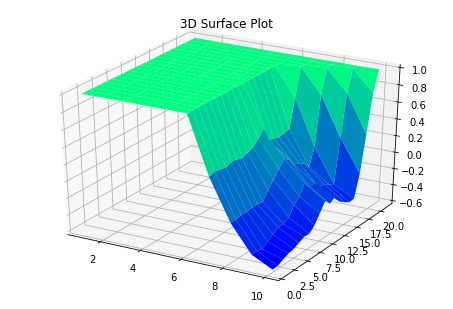

In [51]:
plot_optimal_value(MC_optimal_value)

# Plotting the mean-squared error against λ of Sarsa(λ) learning

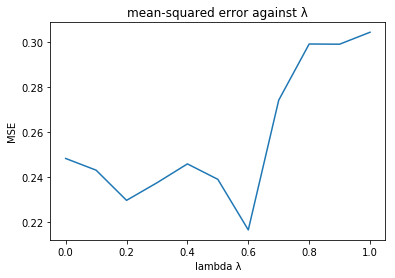

In [79]:
plot_MSE(MC_agent_optimal)

# Plotting the mean-squared error against λ of Linear Function Approximation using Sarsa(λ)

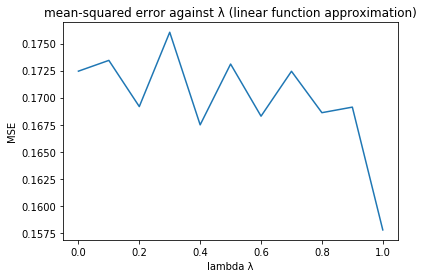

In [77]:
plot_MSE_approx(MC_agent)

# Learning Curve of mean-squared error against episode number of Sarsa(λ)

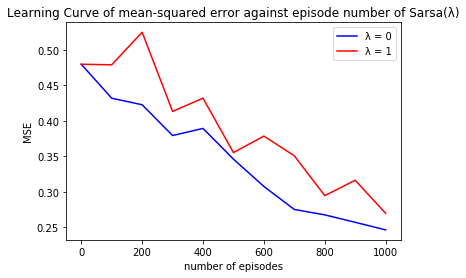

In [104]:
plot_learning_curve(MC_agent)

# Learning Curve of mean-squared error against episode number of Linear Function Approximation 

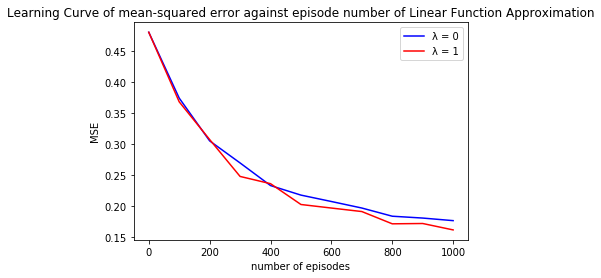

In [105]:
plot_learning_curve_approx(MC_agent)

# Discussion

* What are the pros and cons of bootstrapping in Easy21?


* Would you expect bootstrapping to help more in blackjack or Easy21? Why?


* What are the pros and cons of function approximation in Easy21?


* How would you modify the function approximator suggested in this section to get better results in Easy21?
